# SSML Urbanization Project for 2015

Classification of Urban Areas in Surat, India, using SVM and Random Forest Machine Learning Models

Ana, Marta, and Jirush

Resources:
- For ML models: https://github.com/jonwangio/uu_ml


The notebooks for the models we are running:

- SVM: https://github.com/jonwangio/uu_ml/blob/main/CLA_2_svm(1of%202).ipynb and https://github.com/jonwangio/uu_ml/blob/main/CLA_2_svm(2of2).ipynb

- RF: https://github.com/jonwangio/uu_ml/blob/main/CLA_3_tree_based.ipynb and https://github.com/jonwangio/uu_ml/blob/main/REG_4_additive_trees.ipynb


### 1) For 2015:

In [ ]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import tree
import seaborn as sns
#% pip install geopandas
import geopandas as gpd
#% pip install rasterio
import rasterio
from rasterio.plot import show
from rasterio import features
import os
from sklearn import cluster

In [ ]:
# Read in the images and view 

# Mounting the Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Read in the images 

# Data dir
data_dir = "data2015"
fp_2015band1 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B1.TIF")

# Open the file (band 1):
raster_2015band1 = rasterio.open(fp_2015band1)

# Check type of the variable 'raster'
type(raster_2015band1)

# Read in the other bands
fp_2015band2 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B2.TIF")
fp_2015band3 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B3.TIF")
fp_2015band4 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B4.TIF")
fp_2015band5 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF")
fp_2015band6 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B6.TIF")
fp_2015band7 = os.path.join(data_dir, "LC08_L2SP_148045_20150330_20200909_02_T1_SR_B7.TIF")

# Open the files (band 2-7):
raster_2015band2 = rasterio.open(fp_2015band2)
raster_2015band3 = rasterio.open(fp_2015band3)
raster_2015band4 = rasterio.open(fp_2015band4)
raster_2015band5 = rasterio.open(fp_2015band5)
raster_2015band6 = rasterio.open(fp_2015band6)
raster_2015band7 = rasterio.open(fp_2015band7)

In [ ]:
# Projection
import pprint
pprint.pprint(raster_2015band1.crs)

# Dimensions (units = number of pixels) 
print(raster_2015band1.width)
print(raster_2015band1.height)

CRS.from_epsg(32643)
7681
7821


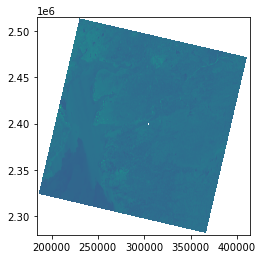

<AxesSubplot:>

In [ ]:
show(raster_2015band2)

In [ ]:
import glob
glist = glob.glob("data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B*.TIF")
glist

['data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B4.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B6.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B7.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B3.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B2.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B1.TIF']

In [ ]:
glist.sort() 

In [ ]:
glist

['data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B1.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B2.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B3.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B4.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B6.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B7.TIF']

In [ ]:
# stack the bands 

# Create a single multispectral image from the individual bands
def stack_bands(file_list, destination_file):
    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(destination_file, 'w', **meta) as dst:
        for id, band in enumerate(file_list, start=1):
            with rasterio.open(band) as src1:
                dst.write_band(id, src1.read(1))
    print(destination_file, ' written to disk')

file_list = glob.glob("data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B*.TIF")
dest_fp = "data2015/LS_stack_2015.tif"
stack_bands(file_list, dest_fp)

data2015/LS_stack_2015.tif  written to disk


In [ ]:
# Open the stacked image of 2015
landsat_ds = rasterio.open('data2015/LS_stack_2015.tif')
landsat_arr3D = landsat_ds.read()

# Reshape the data into columns and create a pandas DataFrame with columns labelled B1 to B7.
bands, nrows, ncols = landsat_arr3D.shape
landsat_arr2D = landsat_arr3D.reshape(bands, nrows*ncols).T
df = pd.DataFrame(data=landsat_arr2D, columns=['B1_CE', 'B2_Blue', 'B3_Green', 'B4_Red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2'])


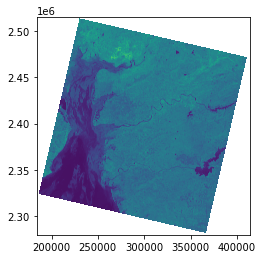

<AxesSubplot:>

In [ ]:
show(landsat_ds)

In [ ]:
df

,B1_CE,B2_Blue,B3_Green,B4_Red,B5_NIR,B6_SWIR1,B7_SWIR2
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
60073096,0,0,0,0,0,0,0
60073097,0,0,0,0,0,0,0
60073098,0,0,0,0,0,0,0
60073099,0,0,0,0,0,0,0


Easier Calculation of NDVI, NDWI, NDBI: 
in the separate file

In [ ]:
red = landsat_ds.read(4)
blue = landsat_ds.read(2)
green = landsat_ds.read(3)
nir = landsat_ds.read(5)
swir = landsat_ds.read(6)

In [ ]:
# Calculation of NDVI, NDBI, NDWI
def NDVI(red, nir, nodata_val):
    """Calculate the Normalized Difference Vegetation Index"""
    nir = nir.astype('f8')
    nir = np.where(nir == nodata_val, np.nan, nir)
    red = red.astype('f8')
    red = np.where(red == nodata_val, np.nan, red)
    NDVI = (nir - red) / (nir + red)
    return NDVI

ndvi_2015 = NDVI(red, nir, 0)

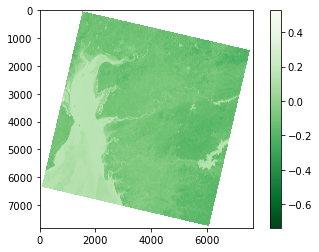

In [ ]:
%matplotlib inline
# Plot the NDBI
plt.imshow(ndvi_2015, cmap='Greens_r')
# Add colorbar to show the index
plt.colorbar()

In [ ]:
def NDWI(green, nir, nodata_val):
    """Calculate the Normalized Difference Vegetation Index"""
    nir = nir.astype('f8')
    nir = np.where(nir == nodata_val, np.nan, nir)
    green = green.astype('f8')
    green = np.where(green == nodata_val, np.nan, green)
    NDWI = (green - nir) / (green + nir) 
    return NDWI

ndwi_2015 = NDWI(green, nir, 0)

In [ ]:
def NDBI(swir, nir, nodata_val):
    """Calculate the Normalized Difference Vegetation Index"""
    nir = nir.astype('f8')
    nir = np.where(nir == nodata_val, np.nan, nir)
    swir = swir.astype('f8')
    swir = np.where(swir == nodata_val, np.nan, swir)
    NDBI = (swir - nir) / (swir + nir)
    return NDBI

ndbi_2015 = NDBI(swir, nir, 0)

In [ ]:
ndbi_2015

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
ndbi_2015.shape

(7821, 7681)

In [ ]:
glist

['data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B1.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B2.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B3.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B4.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B6.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B7.TIF']

In [ ]:
# stack the bands 
file_list_nd = glist
dest_fp_nd = "data2015/ND_stack_2015_2.tif"
stack_bands(file_list_nd, dest_fp_nd)

data2015/ND_stack_2015_2.tif  written to disk


In [ ]:
# Open the stacked image of 2015
nd_calcs_ds = rasterio.open('data2015/ND_stack_2015_2.tif')
nd_calcs_arr3D = nd_calcs_ds.read()

# Reshape the data into columns and create a pandas DataFrame with columns labelled B1 to B7.
bands, nrows, ncols = nd_calcs_arr3D.shape
nd_calcs_arr2D = nd_calcs_arr3D.reshape(bands, nrows*ncols).T
df_nd2 = pd.DataFrame(data=nd_calcs_arr2D, columns=['B1_CE', 'B2_Blue', 'B3_Green', 'B4_Red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2'])

In [ ]:
df_nd2 # dataframe with all 10 bands (includes ndbi, ndvi, and ndwi)

,B1_CE,B2_Blue,B3_Green,B4_Red,B5_NIR,B6_SWIR1,B7_SWIR2
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
60073096,0,0,0,0,0,0,0
60073097,0,0,0,0,0,0,0
60073098,0,0,0,0,0,0,0
60073099,0,0,0,0,0,0,0


In [ ]:
df_nd2.B1_CE.unique()

array([    0,  9450,  9227, ..., 16220, 14656, 14395], dtype=uint16)

Load and Rasterize the AOIs:


In [ ]:
# Labels from the AOIs
aoi = gpd.read_file("polygons_2015/merged_polygons_new2.shp")
aoi['aoi_cat'] = pd.Categorical(aoi['category'])

In [ ]:
def categorise(row):  
    if row['category'] == "water":
        return 1
    elif row['category'] == "buildup":
        return 2
    elif row['category'] == "vegetation":
        return 3
    return 4

aoi['aoi_cat'] = aoi.apply(lambda row: categorise(row), axis=1)

In [ ]:
aoi

,id,category,geometry,aoi_cat
0,2,water,"POLYGON ((249778.344 2382368.634, 242775.889 2...",1
1,3,water,"POLYGON ((225787.616 2340077.578, 209785.306 2...",1
2,4,water,"POLYGON ((251447.762 2337421.370, 234375.707 2...",1
3,7,water,"POLYGON ((359783.989 2349646.488, 366545.274 2...",1
4,8,water,"POLYGON ((347095.604 2409005.300, 349159.113 2...",1
...,...,...,...,...
126,307,water,"POLYGON ((223442.124 2448562.773, 223534.323 2...",1
127,308,sand,"POLYGON ((235458.771 2466772.142, 240499.002 2...",4
128,309,buildup,"POLYGON ((244993.719 2477912.896, 245831.197 2...",2
129,310,vegetation,"POLYGON ((243357.181 2486771.715, 242727.152 2...",3


In [ ]:
# To rasterize the manually created classes in the AOIs 
from rasterio import features

# Rasterize
rst = landsat_ds
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'data2015/aoi_rasterized_nd.tif'
with rasterio.open(out_rst, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [ ]:
file_list

['data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B4.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B6.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B7.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B3.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B2.TIF',
 'data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B1.TIF']

In [ ]:
# stack again (with the github code)
from matplotlib.pyplot import imread

# Read the files and stack them together by calling their names
# Use the 'for' loop to iterate over the names to read files
stack = np.array([])  # Empty array to store the stacked images
for file in file_list_nd:
    print(file)
    img = imread(file)  # Read each image file
    print(img.shape)  # Each time, also check the size of the image
    
    # In order to do clustering, image should be reshaped into a single column
    img_col = img.reshape(-1, 1)
    
    # Each time put the reshaped image into the stack
    stack = np.hstack((stack,img_col)) if stack.size else img_col
    # Also to check the size of the stack
    print(stack.shape)

data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B1.TIF
(7821, 7681)
(60073101, 1)
data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B2.TIF
(7821, 7681)
(60073101, 2)
data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B3.TIF
(7821, 7681)
(60073101, 3)
data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B4.TIF
(7821, 7681)
(60073101, 4)
data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF
(7821, 7681)
(60073101, 5)
data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B6.TIF
(7821, 7681)
(60073101, 6)
data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B7.TIF
(7821, 7681)
(60073101, 7)


In [ ]:
stack

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

ADD THE CALCULATED NDVIs (which are also arrays):

In [ ]:
# use np.hstack
# In order to do clustering, image should be reshaped into a single column
ndbi_2015_col = ndbi_2015.reshape(-1, 1)
stack2 = np.hstack((stack,  ndbi_2015_col))

In [ ]:
ndvi_2015_col = ndvi_2015.reshape(-1, 1)
stack3 = np.hstack((stack2,  ndvi_2015_col))

In [ ]:
ndwi_2015_col = ndwi_2015.reshape(-1, 1)
stack_final = np.hstack((stack3,  ndwi_2015_col))
stack_final

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])

In [ ]:
# Load the rasterized LULC types in the AOI and concatenate it together with the images

aoi_rst = rasterio.open('data2015/aoi_rasterized_nd.tif').read(1)

# Stack the label with the input bands
data = np.c_[stack_final, aoi_rst.reshape(-1,)]

# Of course, we are only interested in pixels with LULC type labelled
data_2015 = data[np.where(data[:,data.shape[1]-1]!=0)]

In [ ]:
data_2015.shape

(2427849, 11)

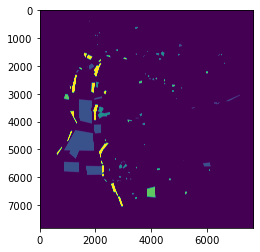

<AxesSubplot:>

In [ ]:
show(aoi_rst)

In [ ]:
data_2015
#type(data)

array([[ 1.02860000e+04,  1.14620000e+04,  1.35200000e+04, ...,
        -1.41205615e-01,  1.78490050e-01,  2.00000000e+00],
       [ 1.00990000e+04,  1.10590000e+04,  1.29000000e+04, ...,
        -1.34257240e-01,  1.71350570e-01,  2.00000000e+00],
       [ 9.58900000e+03,  1.04970000e+04,  1.20750000e+04, ...,
        -1.60963068e-01,  1.99111229e-01,  2.00000000e+00],
       ...,
       [ 9.41600000e+03,  9.81900000e+03,  1.07030000e+04, ...,
         1.59023228e-01, -1.48698685e-01,  4.00000000e+00],
       [ 9.44200000e+03,  9.82600000e+03,  1.08400000e+04, ...,
         1.63839382e-01, -1.50682023e-01,  4.00000000e+00],
       [ 9.16000000e+03,  9.48200000e+03,  1.02400000e+04, ...,
         9.42509083e-02, -7.09616692e-02,  4.00000000e+00]])

Band division

In [ ]:
#data to dataframe
lulc_2015 = pd.DataFrame(data_2015, columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDBI','NDVI','NDWI', 'aoi'])
lulc_2015

,B1,B2,B3,B4,B5,B6,B7,NDBI,NDVI,NDWI,aoi
0,10286.0,11462.0,13520.0,15054.0,18353.0,19395.0,17966.0,-0.082379,-0.141206,0.178490,2.0
1,10099.0,11059.0,12900.0,14134.0,17104.0,18235.0,16901.0,-0.076840,-0.134257,0.171351,2.0
2,9589.0,10497.0,12075.0,13259.0,16712.0,18079.0,16708.0,-0.069910,-0.160963,0.199111,2.0
3,9323.0,10262.0,12098.0,13154.0,16979.0,17964.0,16336.0,-0.082111,-0.149047,0.195130,2.0
4,9342.0,10359.0,12340.0,13556.0,16462.0,18563.0,17224.0,-0.087273,-0.165201,0.201372,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2427844,9258.0,9630.0,10578.0,10857.0,8827.0,7900.0,7743.0,-0.046912,0.154740,-0.144929,4.0
2427845,9289.0,9639.0,10590.0,10868.0,8820.0,7924.0,7761.0,-0.047012,0.154161,-0.143999,4.0
2427846,9416.0,9819.0,10703.0,11060.0,9309.0,7932.0,7766.0,-0.043076,0.159023,-0.148699,4.0
2427847,9442.0,9826.0,10840.0,11142.0,9216.0,8001.0,7788.0,-0.049066,0.163839,-0.150682,4.0


In [ ]:
lulc_2015_accuracy = lulc_2015.iloc[:,:-1]

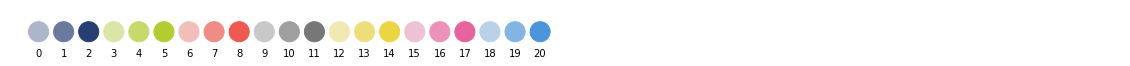

In [ ]:
# colors for plot
# We also prepare the color codes for visualization
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50), (75, 90, 85), (347, 72, 60), (246, 79, 60)]
cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=4)
    for rgb in pal[1:]:
        cols.append(rgb)

# A preview of color codes. Please delete the triple quotation marks to run the code.

fig, ax = plt.subplots(figsize=(20, 5))
for i, c in enumerate(cols):
    ax.add_artist(plt.Circle((i, 0), 0.4, color=c))
    plt.text(i, -1, i, horizontalalignment='center')
    ax.set_axis_off()
    ax.set_aspect(1)
    ax.autoscale()
    plt.xlim(-1.25,43.25)
    plt.ylim(-1,1)


# Assign color codes to LULC types 
symbology = {'water': cols[19],
             'buildup': cols[8],
             'vegetation': cols[5],
             'sand': cols[13]}

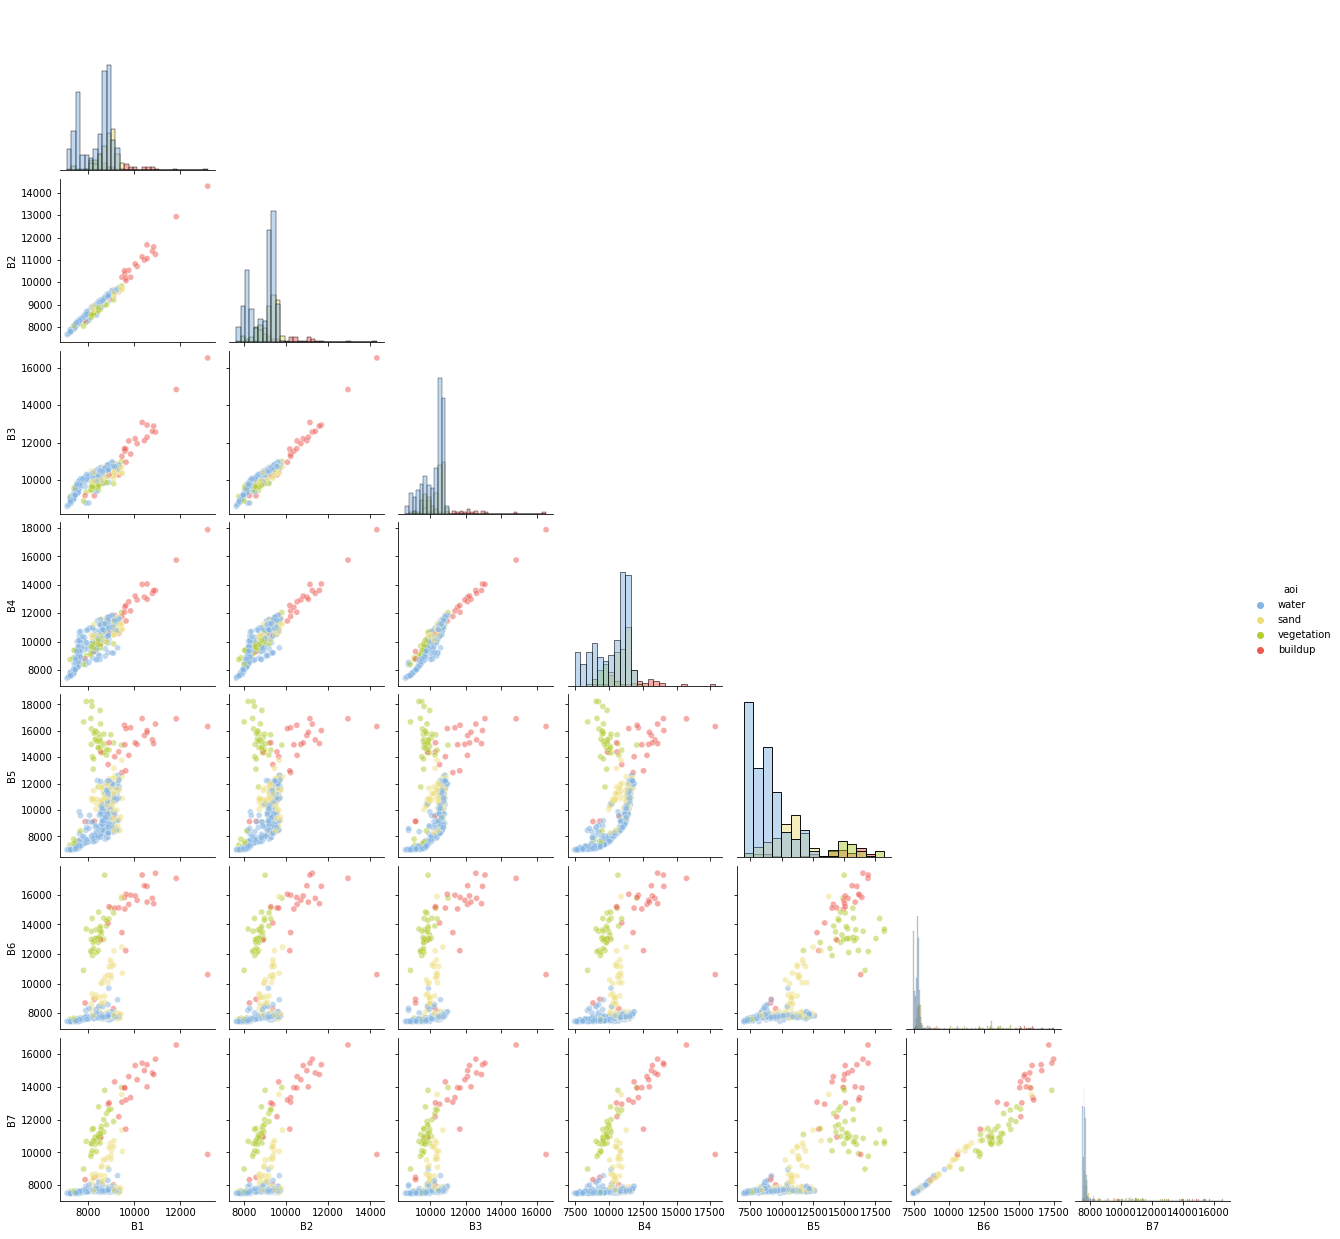

In [ ]:
# As you can see, we are using a subset of the dataset for "speed" plotting
lulc_sub = lulc_2015.sample(500)

# Adjust aoi numbers to land cover
#aoi['aoi_cat'] = pd.Categorical(aoi['category'])
classes = aoi.loc[:,['category', 'aoi_cat']].drop_duplicates()
class_dict = {k:v for k,v in zip(classes.aoi_cat, classes.category)}
lulc_sub.replace({'aoi': class_dict}, inplace=True)
sns.pairplot(lulc_sub.loc[:,['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'aoi']], 
             hue='aoi', palette=symbology, diag_kind="hist", 
             corner=True, 
             plot_kws=dict(linewidth=0.5, alpha=0.5))


In [ ]:
# sampling equal amount of each class
import random
random.seed(10)
sample_size = 170000
lulc_2015_sample = lulc_2015.groupby('aoi').apply(lambda x: x.sample(sample_size))

# check number of rows
lulc_2015_sample.shape[0]

680000

In [ ]:
# change df to array (needed for later analysis)
lulc_2015_sample = lulc_2015_sample.to_numpy()
type(lulc_2015_sample)
lulc_2015_sample.shape

data_2015 = lulc_2015_sample

In [ ]:
#This is to replace nan with zero and inf with finite numbers
#Code is taken from: https://datascience.stackexchange.com/questions/11928/valueerror-input-contains-nan-infinity-or-a-value-too-large-for-dtypefloat32

#np.where(np.isnan(lulc_2015))
data_2015 = np.nan_to_num(data_2015)

Train/Test Split

In [ ]:
# Recall our function for preparing training and test datasets.
# This time we re-write it a little bit to let the users of the function to split the data into training and test sets.

def trainTestSplit(x, y, training_proportion):
    data = np.c_[x, y]
    np.random.shuffle(data)  # Shuffle the data so that LULC types can spread over training and test sets
    x_train = data[:int(training_proportion*len(data)), :10]  # 70% of data for training
    x_test = data[int(training_proportion*len(data)):, :10]  # 30% for testing
    y_train = data[:int(training_proportion*len(data)), 10:].reshape(-1,)  # 70% of data for training
    y_test = data[int(training_proportion*len(data)):, 10:].reshape(-1,)  # 30% for testing
    return x_train, y_train, x_test, y_test

# This time, use a very small proportion of the data for training, say, 30%.
X_train, Y_train, X_test, Y_test = trainTestSplit(data_2015[:,:-1], data_2015[:,-1], 0.3)


In [ ]:
data_2015[int(0.3*len(data_2015)):, 2:].reshape(-1,)

array([ 1.32930000e+04,  1.44360000e+04,  1.63290000e+04, ...,
        1.67260170e-01, -1.57393537e-01,  4.00000000e+00])

In [ ]:
data_2015

array([[ 8.78000000e+03,  9.35900000e+03,  1.06030000e+04, ...,
         1.61845277e-01, -1.54507840e-01,  1.00000000e+00],
       [ 7.64800000e+03,  8.28900000e+03,  9.92000000e+03, ...,
         1.39313196e-01, -1.42067695e-01,  1.00000000e+00],
       [ 8.79100000e+03,  9.35400000e+03,  1.06970000e+04, ...,
         1.64109261e-01, -1.54373280e-01,  1.00000000e+00],
       ...,
       [ 8.81200000e+03,  9.30800000e+03,  1.05770000e+04, ...,
         1.60204026e-01, -1.54064375e-01,  4.00000000e+00],
       [ 8.45600000e+03,  8.80500000e+03,  9.59600000e+03, ...,
         3.38289162e-02,  4.16666667e-04,  4.00000000e+00],
       [ 9.14000000e+03,  9.64300000e+03,  1.08170000e+04, ...,
         1.67260170e-01, -1.57393537e-01,  4.00000000e+00]])

## ML Models:

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(204000, 10)
(204000,)


### 2) Decision Tree

[Text(0.5, 0.9, 'X[0] <= 9409.5\ngini = 0.75\nsamples = 204000\nvalue = [51295, 51257, 50616, 50832]'),
 Text(0.25, 0.7, 'X[0] <= 7772.5\ngini = 0.723\nsamples = 168699\nvalue = [51185, 18028, 49667, 49819]'),
 Text(0.125, 0.5, 'X[0] <= 7367.5\ngini = 0.377\nsamples = 23980\nvalue = [17982, 70, 5928, 0]'),
 Text(0.0625, 0.3, 'X[0] <= 7216.5\ngini = 0.501\nsamples = 6455\nvalue = [3332, 10, 3113, 0]'),
 Text(0.03125, 0.1, 'gini = 0.487\nsamples = 1883\nvalue = [776, 4, 1103, 0]'),
 Text(0.09375, 0.1, 'gini = 0.494\nsamples = 4572\nvalue = [2556, 6, 2010, 0]'),
 Text(0.1875, 0.3, 'X[0] <= 7695.5\ngini = 0.275\nsamples = 17525\nvalue = [14650, 60, 2815, 0]'),
 Text(0.15625, 0.1, 'gini = 0.237\nsamples = 15850\nvalue = [13678, 37, 2135, 0]'),
 Text(0.21875, 0.1, 'gini = 0.498\nsamples = 1675\nvalue = [972, 23, 680, 0]'),
 Text(0.375, 0.5, 'X[0] <= 8529.5\ngini = 0.722\nsamples = 144719\nvalue = [33203, 17958, 43739, 49819]'),
 Text(0.3125, 0.3, 'X[0] <= 8131.5\ngini = 0.582\nsamples = 4000

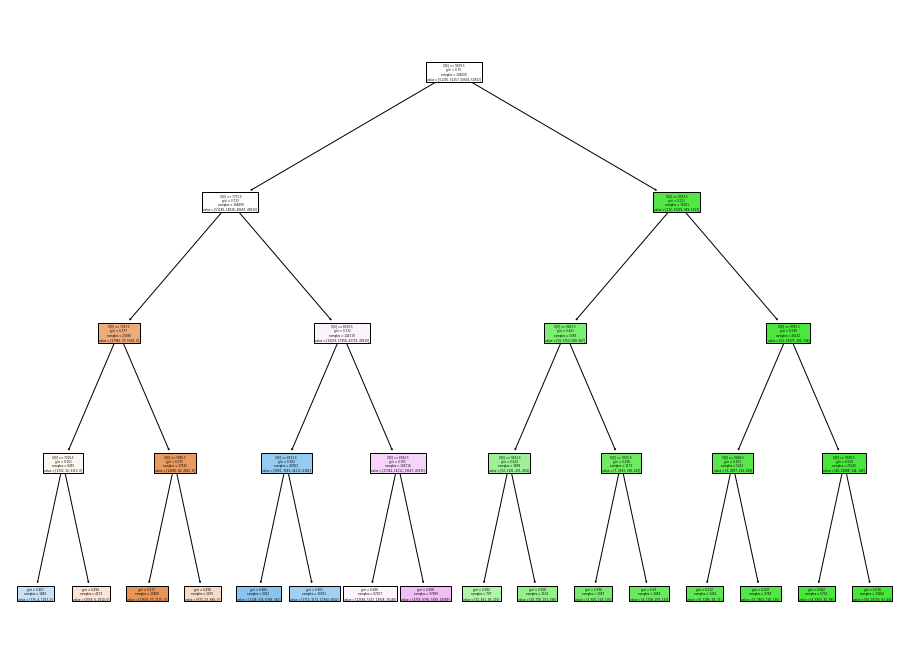

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score,mean_squared_error

# Initiate a tree model
tree_depth = 4
model_tree = DecisionTreeClassifier(max_depth=tree_depth)

# Fit the model to your data.
# Please note that the output of t his fitting is a model with several parameters that are configurable, so far you only configured "max_depth" while training/fitting.
model_tree.fit(X_train[:,0].reshape(-1,1), Y_train)

# Visualize split
fig = plt.figure(figsize=(tree_depth*4,tree_depth*3))
tree.plot_tree(model_tree, filled=True)

In [ ]:
# Confusion Matrix
Y_pred = pd.Series(list(model_tree.predict(X_test[:,0].reshape(-1,1))), name='DT prediction')  # Store the predicted value in Y_pred
Y_actu = pd.Series(list(Y_test), name='Manual delineation')

# Map the LULC codes to the actual name of LULC types

# First we need a mapping from the LULC codes to the actual LULC type name.
code_lulc = { 19: 'water',
              8: 'buildup',
              5: 'vegetation',
            13: 'sand'}


# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
Y_actu2 = Y_actu.replace(code_lulc)
Y_pred2 = Y_pred.replace(code_lulc)

# Show the LULC coded confusion matrix
df_confusion2 = pd.crosstab(Y_actu2, Y_pred2)
df_confusion2

DT prediction,1.0,2.0,3.0,4.0
Manual delineation,,,,
1.0,39481,236,15479,63509
2.0,148,77111,8879,32605
3.0,11318,2383,59456,46227
4.0,0,2296,14523,102349


In [ ]:
# Print out more detailed accuracy assessment report

from sklearn.metrics import classification_report

print(classification_report(Y_actu2, Y_pred2))

              precision    recall  f1-score   support

         1.0       0.77      0.33      0.47    118705
         2.0       0.94      0.65      0.77    118743
         3.0       0.60      0.50      0.55    119384
         4.0       0.42      0.86      0.56    119168

    accuracy                           0.58    476000
   macro avg       0.68      0.58      0.59    476000
weighted avg       0.68      0.58      0.59    476000



## Random Forest CLASSIFICATION - with all polygons & NDBI, NBVI, NDWI 

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,Y_train)

Y_pred_rf=clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred_rf))

Accuracy: 0.9662857142857143


In [ ]:
# predict again with the tree interpreter to see how much each band contributes to the classification
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [ ]:
# plot the contributions
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDBI','NDVI','NDWI']

gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
gdf.style.background_gradient(cmap='viridis')

,"('water', 1)","('buildup', 2)","('vegetation', 3)","('sand', 4)"
B1,1.077614,-0.684763,-0.309222,-0.083629
B2,0.834129,-1.786816,0.943127,0.009560
B3,0.023986,-0.627880,0.459376,0.144518
B4,0.755300,-0.179536,0.452112,-1.027876
B5,2.334115,-0.284938,-0.972537,-1.076639
B6,0.676896,-0.112658,-0.294529,-0.269708
B7,0.688287,-0.357323,-0.374776,0.043812
NDBI,0.208670,0.244063,-0.366640,-0.086094
NDVI,0.369533,0.055095,-0.282190,-0.142439
NDWI,0.665857,-0.199343,-0.799289,0.332775


In [ ]:
print (clf.score(X_train,Y_train))
print(clf.score(X_test, Y_pred_rf))

0.9999950980392157
1.0


In [ ]:
print (clf.score(X_train,Y_train))
print(clf.score(X_test, Y_test))

0.9999950980392157
0.9662857142857143


In [ ]:
cm = metrics.confusion_matrix(Y_test, Y_pred_rf,  labels = [1, 2, 3, 4])

In [ ]:
pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,1.0,2.0,3.0,4.0
Actual Result,,,,
1.0,115030,169,205,3301
2.0,65,113652,3761,1265
3.0,182,2479,116636,87
4.0,2714,1659,161,114634


In [ ]:
pd.DataFrame(clf.feature_importances_, index=lulc_2015_accuracy.columns).sort_values(by=0, ascending=False)

,0
B5,0.195195
B2,0.125761
NDWI,0.109597
B3,0.099590
B1,0.096790
B7,0.093296
B4,0.080224
B6,0.078505
NDVI,0.076074
NDBI,0.044968


B2 & B5 match the big plots

### Predicting for the whole stacked image

In [ ]:
stack_final_cleaned = np.nan_to_num(stack_final)

In [ ]:
# Predict on the image stack

Y_pred_all = clf.predict(stack_final_cleaned)

In [ ]:
'''
# Assign color codes to LULC types 
symbology2 =  { 19: 'water',
              8: 'buildup',
              5: 'vegetation',
            13: 'sand'}

# Visualize
# Because the predicted labels are still in one column, you need to reshape it back to original image shape
row, col = img.shape  # Get the original dimensions of the image
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

print('Printing large image takes time...')
ax2.imshow(Y_pred_all, cmap=cm, interpolation='none', vmin=imin, vmax=imax)
'''

"\n# Assign color codes to LULC types \nsymbology2 =  { 19: 'water',\n              8: 'buildup',\n              5: 'vegetation',\n            13: 'sand'}\n\n# Visualize\n# Because the predicted labels are still in one column, you need to reshape it back to original image shape\nrow, col = img.shape  # Get the original dimensions of the image\nimin = min(symbology2)  # Colormap range\nimax = max(symbology2)\n\nprint('Printing large image takes time...')\nax2.imshow(Y_pred_all, cmap=cm, interpolation='none', vmin=imin, vmax=imax)\n"

In [ ]:
row,col = img.shape

In [ ]:
# Again we use our image data for georeferencing information
rst = rasterio.open('data2015/LC08_L2SP_148045_20150330_20200909_02_T1_SR_B5.TIF')
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'rf_prediction_2015.tif'
out_file = rasterio.open(
    out_rst,
    'w',
    driver='GTiff',
    height=row,
    width=col,
    count=1,
    dtype=Y_pred_all.dtype,
    crs=rst.crs,
    transform=rst.transform)

out_file.write(Y_pred_all.reshape(row, col),1)
out_file.close()

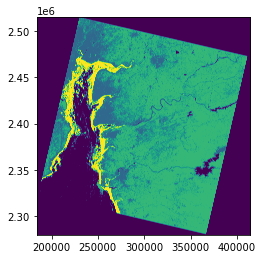

<AxesSubplot:>

In [ ]:
rf_tif = rasterio.open('rf_prediction_2015.tif')
show(rf_tif)

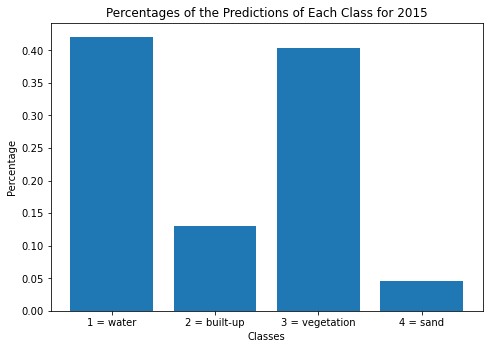

In [ ]:
# histogram of the prediction labels
unique, counts = np.unique(Y_pred_all, return_counts=True)
results = np.column_stack((unique,counts))
summed_counts = sum(counts)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['1 = water', '2 = built-up', '3 = vegetation', '4 = sand']
ax.set_title('Percentages of the Predictions of Each Class for 2015')
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.bar(classes, counts/summed_counts)
plt.show()

In [ ]:
print(counts/summed_counts)

[0.42107382 0.13064455 0.40274868 0.04553296]


In [ ]:
print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

         1.0       0.97      0.97      0.97    118705
         2.0       0.96      0.96      0.96    118743
         3.0       0.97      0.98      0.97    119384
         4.0       0.96      0.96      0.96    119168

    accuracy                           0.97    476000
   macro avg       0.97      0.97      0.97    476000
weighted avg       0.97      0.97      0.97    476000

